## Access Kaggle
Serveral things you need to do to access Kaggle
- Sign in to Kaggle and join the competition called **BCI Homework 3 Kaggle Judge** (using the link we provide in the document)

- Create your own kaggle API token (in your account->API)
  
  <img src="https://i.imgur.com/Gia6TwE.png" alt="drawing" width="800"/>
- Upload API token (.json file) to Colab 

   <img src="https://i.imgur.com/xjEXBYs.png" alt="drawing" width="200"/>

In [ ]:
!mkdir -p /root/.kaggle
!mv kaggle.json /root/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions list

## Download Dataset from Kaggle

In [ ]:
!kaggle competitions download -c bci-homework-3-kaggle-judge
!unzip -qq bci-homework-3-kaggle-judge.zip -d ./
!ls -l BCI_hw3_dataset

 96% 270M/282M [00:03<00:00, 144MB/s]
100% 282M/282M [00:03<00:00, 83.7MB/s]
total 16
-rw-r--r-- 1 root root  269 Apr 12 08:33 data_detail.json
drwxr-xr-x 2 root root 4096 Apr 12 10:11 labeled_test
drwxr-xr-x 2 root root 4096 Apr 12 10:11 train
drwxr-xr-x 2 root root 4096 Apr 12 10:11 unlabeled_test


## Install Package (Optional)

In [ ]:
!pip install torchinfo
!pip install mne

## Import Package and Library to Python Session

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
import torch.nn.functional as F

from matplotlib import pyplot as plt
from scipy.io import loadmat
from scipy.io import savemat
import numpy as np
import math
import time
import csv
import mne
import sys
import os

DATASET_DIR = "BCI_hw3_dataset/train"
DATASET_DIR_TEST = "BCI_hw3_dataset/labeled_test"
DATASET_DIR_EXAM = "BCI_hw3_dataset/unlabeled_test"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

C:\Users\user\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## EEG Model

### EEGNet

In [2]:
class EEGNet(nn.Module):
    """EEGNet model from Lawhern et al 2018.
    ... Parameters ............
    C: int
        Number of EEG input channels.
    N: int
        Number of EEG input time samples.
    nb_classes: int
        Number of classes to predict.
    kernLength: int
        Length of temporal convolution in first layer.
    F1, F2: int
        Number of temporal filters (F1) and number of pointwise filters (F2) to learn.
    D: int
        Number of spatial filters to learn within each temporal convolution.
    dropoutRate: float
        Dropout ratio.
    ... References ............
    https://arxiv.org/abs/1611.08024
    """
    def __init__(self, C, N, nb_classes, kernLength=64, F1=8, F2=16, D=2, dropoutRate=0.5):
        super(EEGNet, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, F1, (1, kernLength), padding="valid", bias=False),
            nn.BatchNorm2d(F1, eps=1e-3, momentum=0.99)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                F1, D * F1, (C, 1), groups=F1, bias=False
            ),
            nn.BatchNorm2d(D * F1, eps=1e-3, momentum=0.99),
            nn.ELU(),
            nn.AvgPool2d((1, 4)),
            nn.Dropout(dropoutRate)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(
                D * F1, D * F1, (1, 16),
                padding=(0, 8), groups=D * F1, bias=False
            ),
            nn.Conv2d(D * F1, F2, (1, 1), bias=False),
            nn.BatchNorm2d(F2, eps=1e-3, momentum=0.99),
            nn.ELU(),
            nn.AvgPool2d((1, 8)),
            nn.Dropout(dropoutRate)
        )

        fc_inSize = self.get_size(C, N)[1]
        self.classifier = nn.Linear(fc_inSize, nb_classes, bias=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size()[0], -1)
        x = self.classifier(x)
        return x

    def get_size(self, C, N):
        data = torch.ones((1, 1, C, N))
        x = self.conv1(data)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size()[0], -1)
        return x.size()


### ShallowConvNet

In [3]:
class ShallowConvNet(nn.Module):
    """Shallow ConvNet model from Schirrmeister et al 2017.
    ... Parameters ............
    C: int
        Number of EEG input channels.
    N: int
        Number of EEG input time samples.
    nb_classes: int
        Number of classes to predict.
    NT: int
        Number of temporal filters.
    NS: int
        Number of spatial filters.
    tkerLen: int
        Length of the temporal filter.
    pool_tLen: int
        Length of temporal pooling filter.
    pool_tStep: int
        Length of stride of temporal pooling filters.
    batch_norm: bool
        Whether to use batch normalization.
    dropRate: float
        Dropout ratio.
    ... References ............
    https://arxiv.org/abs/1703.05051
    """
    def __init__(self, C, N, nb_classes, NT=40, NS=40, tkerLen=12, pool_tLen=35, pool_tStep=7, batch_norm=True, dropoutRate=0.25):
        super(ShallowConvNet, self).__init__()

        self.conv1 = nn.Conv2d(1, NT, (1, tkerLen), bias=False)
        self.conv2 = nn.Conv2d(NT, NS, (C, 1), bias=False)
        self.Bn1 = nn.BatchNorm2d(NS)
        self.AvgPool1 = nn.AvgPool2d((1, pool_tLen), stride=(1, pool_tStep))
        self.Drop1 = nn.Dropout(dropoutRate)
        fc_inSize = self.get_size(C, N)[1]
        self.classifier = nn.Linear(fc_inSize, nb_classes, bias=True)
        self.batch_norm = batch_norm

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        if self.batch_norm:
            x = self.Bn1(x)
        x = x ** 2
        x = self.AvgPool1(x)
        x = torch.log(x)
        x = self.Drop1(x)
        x = x.view(x.size()[0], -1)
        x = self.classifier(x)
        return x
    
    def get_size(self, C, N):
        data = torch.ones((1, 1, C, N))
        x = self.conv1(data)
        x = self.conv2(x)
        x = self.AvgPool1(x)
        x = x.view(x.size()[0], -1)
        return x.size()


### SCCNet_v2

In [4]:
# (Bonus) Optional TODO: Advanced SCCNet model without permutation layer
class SCCNet_v2(nn.Module):
    """Advanced SCCNet model without permutation layer.
    ... Parameters ............
    C: int
        Number of EEG input channels.
    N: int
        Number of EEG input time samples.
    nb_classes: int
        Number of classes to predict.
    Nu: int
        Number of spatial kernel.
    Nt: int
        Length of spatial kernel.
    Nc: int
        Number of spatial-temporal kernel.
    fs: float
        Sampling frequency of EEG input.
    dropoutRate: float
        Dropout ratio.
    ... References ............
    https://ieeexplore.ieee.org/document/8716937
    """
    def __init__(self, C, N, nb_classes, Nu=None, Nt=1, Nc=20, fs=1000.0, dropoutRate=0.5):
        super(SCCNet_v2, self).__init__()
        Nu = C if Nu is None else Nu
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=Nu, kernel_size=(C, Nt), padding=0),
            # Permute2d((0,2,1,3)),
            nn.BatchNorm2d(Nu)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=Nu, out_channels=Nc, kernel_size=(Nt, math.floor(fs*0.1)), padding=(0, int(math.floor(fs*0.1)/2))),
            nn.BatchNorm2d(Nc)
        )
        self.dropout = nn.Dropout(dropoutRate)
        self.Avgpool = nn.AvgPool2d(kernel_size=(1,math.ceil(fs/2)),stride=(1,12))
        
        fc_inSize = self.get_size(C, N)[1]
        self.classifier = nn.Linear(fc_inSize, nb_classes, bias=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x ** 2
        x = self.dropout(x)
        x = self.Avgpool(x)
        x = torch.log(x) 
        x = x.view(x.size()[0], -1)
        x = self.classifier(x)
        return x
    
    def get_size(self, C, N):
        # Optional TODO: auto calculate fully-connected layer helper function
        data = torch.ones((1, 1, C, N))
        x = self.conv1(data)
        x = self.conv2(x)
        x = self.Avgpool(x)
        x = x.view(x.size()[0], -1)
        return x.size()

### SCCNet

In [5]:
# TODO: finish the SCCNet
    
class SCCNet(nn.Module):
    """SCCNet model from Wei et al 2019.
    ... Parameters ............
    C: int
        Number of EEG input channels.
    N: int
        Number of EEG input time samples.
    nb_classes: int
        Number of classes to predict.
    Nu: int
        Number of spatial kernel.
    Nt: int
        Length of spatial kernel.
    Nc: int
        Number of spatial-temporal kernel.
    fs: float
        Sampling frequency of EEG input.
    dropoutRate: float
        Dropout ratio.
    ... References ............
    https://ieeexplore.ieee.org/document/8716937
    """
    # You can only add extra argument to this function, do NOT remove the existed arguments
    # The model structure should be dynamic changed by the provided arguments,
    # There will be a score penalty if SCCNet structure is static
    def __init__(self, C, N, nb_classes, Nu=None, Nt=1, Nc=20, fs=1000.0, dropoutRate=0.5): 
        super(SCCNet, self).__init__()
        Nu = C if Nu is None else Nu
        ### TODO: construct the model layers, refer to paper ###
         # batch, 1, EEG_channel, EEG_timepoint
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=Nu, kernel_size=(C, Nt), padding=0),
            Permute2d((0,2,1,3)),
            nn.BatchNorm2d(1)
        )
        # Forwarding will permute the metrix (2,1,3)
        # batch, Nu, 1, timepoint -> batch, 1, Nu, timepoint
        #self.permute = Permute2d((0,2,1,3))
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=Nc, kernel_size=(Nu, math.floor(fs*0.1)), padding=(0, int(math.floor(fs*0.1)/2))),
            nn.BatchNorm2d(Nc)
        )
        self.dropout = nn.Dropout(dropoutRate)
        self.Avgpool = nn.AvgPool2d(kernel_size=(1,math.ceil(fs/2)),stride=(1,12))
        
        fc_inSize = self.get_size(C, N)[1]
        self.classifier = nn.Linear(fc_inSize, nb_classes, bias=True)

        # w_out = math.floor((((Samples-11)-62)/12)+1)
        # self.fc = nn.Sequential(
        #    nn.Flatten(),
        #    nn.Linear(20*w_out, nb_classes)
        #)

    def forward(self, x):
        ### TODO: forwarding rule ###
        # ex. x = self.layer(x)
        # note. remember the square activation and log activation
        
        # Input shape : Batch,1,Channel,Timepoint
        x = self.conv1(x)
        x = self.conv2(x)
        x = x ** 2
        x = self.dropout(x)
        x = self.Avgpool(x)
        x = torch.log(x) 
        x = x.view(x.size()[0], -1)
        x = self.classifier(x)
        return x

    def get_size(self, C, N):
        # Optional TODO: auto calculate fully-connected layer helper function
        data = torch.ones((1, 1, C, N))
        x = self.conv1(data)
        x = self.conv2(x)
        x = self.Avgpool(x)
        x = x.view(x.size()[0], -1)
        return x.size()

class Permute2d(nn.Module):
    def __init__(self, shape):
        super(Permute2d, self).__init__()
        self.shape = shape

    def forward(self, x):
        return torch.permute(x, self.shape)

## Train

In [16]:
# config training scheme, mode, hyperparam
eegmodel = SCCNet_v2 # function alias, should be EEGNet, ShallowConvNet, SCCNet, SCCNet_v2
kwargs = dict(fs=125.0, dropoutRate=0.5) # custom args for different EEG model # fs=125.0 only for SCCNet
scheme = "sift"  # "ind", "si", "sd", "sift"
epochs = 150
batch_size = 16
lr = 1e-4
savepath = "checkpoints/SCCNet_" + scheme
os.makedirs(savepath, exist_ok=True)

subject_id = 1

### load data

In [10]:
mat_T = loadmat(os.path.join(DATASET_DIR, "BCIC_S0{}_T.mat".format(subject_id)))
x_data, y_data = mat_T["x_train"], mat_T["y_train"].squeeze()
x_train = np.zeros((0, *x_data.shape[1:]), dtype=x_data.dtype)
y_train = np.zeros((0, ), dtype=y_data.dtype)
x_valid = np.zeros((0, *x_data.shape[1:]), dtype=x_data.dtype)
y_valid = np.zeros((0, ), dtype=y_data.dtype)

if scheme == "si" or scheme == "sift":
    ### TODO: subject-independent training scheme, subject-independent + fine-tuning shared same training data representaion ###
    for sid in range(1, 10):
        if sid != subject_id:
            mat_T = loadmat(os.path.join(DATASET_DIR, "BCIC_S0{}_T.mat".format(sid)))
            x_data, y_data = mat_T["x_train"], mat_T["y_train"].squeeze()
            x_train = np.append(x_train, x_data, axis=0)
            y_train = np.append(y_train, y_data, axis=0)
    for sid in range(2, 5):  
        mat_E = loadmat(os.path.join(DATASET_DIR_TEST, "BCIC_S0{}_E.mat".format(sid)))
        x_data, y_data = mat_E["x_test"], mat_E["y_test"].squeeze()
        x_valid = np.append(x_valid, x_data, axis=0)
        y_valid = np.append(y_valid, y_data, axis=0)
        
elif scheme == "sd": # subject-dependent, target `subject` participate in training stage, `testing data should still be LEAVE-OUT`
    ### TODO: subject-dependent training scheme ###
    for sid in range(1, 10):
        mat_T = loadmat(os.path.join(DATASET_DIR, "BCIC_S0{}_T.mat".format(sid)))
        x_data, y_data = mat_T["x_train"], mat_T["y_train"].squeeze()
        x_train = np.append(x_train, x_data, axis=0)
        y_train = np.append(y_train, y_data, axis=0)
        
    for sid in range(2, 5):  
        mat_E = loadmat(os.path.join(DATASET_DIR_TEST, "BCIC_S0{}_E.mat".format(sid)))
        x_data, y_data = mat_E["x_test"], mat_E["y_test"].squeeze()
        x_valid = np.append(x_valid, x_data, axis=0)
        y_valid = np.append(y_valid, y_data, axis=0)
    
else:  # default subject-individual
    mat_T = loadmat(os.path.join(DATASET_DIR, "BCIC_S0{}_T.mat".format(subject_id))) # load the .mat file
    x_data, y_data = mat_T["x_train"], mat_T["y_train"].squeeze()

    # simple train-valid split, only consider class balance (may not good enough), CAN be modified
    for c in range(4):
        x_, y_ = x_data[y_data == c], y_data[y_data == c]
        x_train = np.append(x_train, x_[:54], axis=0)
        y_train = np.append(y_train, y_[:54], axis=0)
        x_valid = np.append(x_valid, x_[54:], axis=0)
        y_valid = np.append(y_valid, y_[54:], axis=0)      

# numpy array to tensor
x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train).long()
x_valid = torch.from_numpy(x_valid)
y_valid = torch.from_numpy(y_valid).long()

# tensor reshape for training
x_train = x_train.unsqueeze(1)
y_train = F.one_hot(y_train, 4)
x_valid = x_valid.unsqueeze(1)
y_valid = F.one_hot(y_valid, 4)

print("train: {}, {}".format(x_train.size(), y_train.size()))
print("valid: {}, {}".format(x_valid.size(), y_valid.size()))

# build training and validation dataloader
trainset = torch.utils.data.TensorDataset(x_train, y_train)
validset = torch.utils.data.TensorDataset(x_valid, y_valid)
tra_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=True, num_workers=2)

train: torch.Size([2304, 1, 22, 562]), torch.Size([2304, 4])
valid: torch.Size([864, 1, 22, 562]), torch.Size([864, 4])


### training stage

In [11]:
# train an epoch, evaluate an epoch
# if you are familiar with Pytorch, you CAN custom these function
#  such as adding the lr_scheduler to optimize the training progress

def train_an_epoch(model, data_loader, loss_fn, optimizer):
    model.train()
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.9)

    a, b = 0, 0  # hit sample, total sample
    epoch_loss = np.zeros((len(data_loader), ))
    for i, (x_batch, y_batch) in enumerate(data_loader):
        x_batch, y_batch = x_batch.to(device, dtype=torch.float), y_batch.to(device, dtype=torch.float)
        
        ### TODO ###
        # TODO: zero grad optimizer
        optimizer.zero_grad()
        # TODO: get model prediction
        output = model(x_batch)
        # TODO: calc loss
        loss = loss_fn(output, y_batch)
        # TODO: back propagation
        loss.backward()
        # TODO: step the optimizer
        optimizer.step()
        
        epoch_loss[i] = loss.item()
        b += y_batch.size(0)
        a += torch.sum(y_batch.argmax(dim=1) == output.argmax(dim=1)).item()
    scheduler.step()
    return epoch_loss.mean(), a / b  # return the loss and acc

def evalate_an_epoch(model, data_loader, loss_fn):
    model.eval()
    a, b = 0, 0 # hit sample, total sample
    gt, pred = [], []
    epoch_loss = np.zeros((len(data_loader), ))
    with torch.no_grad():
        for i, (x_batch, y_batch) in enumerate(data_loader):
            x_batch, y_batch = x_batch.to(device, dtype=torch.float), y_batch.to(device, dtype=torch.float)
            ### TODO ###
            # TODO: get model prediction
            output = model(x_batch)
            # TODO: calc loss
            loss = loss_fn(output, y_batch)

            epoch_loss[i] = loss.item()
            b += y_batch.size(0)
            a += torch.sum(y_batch.argmax(dim=1) == output.argmax(dim=1)).item()
            
            gt += y_batch.argmax(dim=1).detach().cpu().numpy().tolist()
            pred += output.argmax(dim=1).detach().cpu().numpy().tolist()
            
    return epoch_loss.mean(), a / b, gt, pred  # return the loss and acc


EEGNet

In [11]:
model = eegmodel(x_train.size(2), x_train.size(3), 4, **kwargs)
loss_fn = nn.CrossEntropyLoss()  # loss function, can be modified
opt_fn = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-04)  # optimizer, CAN be modified
# sche_fn = torch.optim.lr_scheduler.<???> # optional

# dump the model structure
summary(model, input_size=(batch_size, *list(x_train.size()[1:])))

Layer (type:depth-idx)                   Output Shape              Param #
EEGNet                                   [16, 4]                   --
├─Sequential: 1-1                        [16, 8, 22, 499]          --
│    └─Conv2d: 2-1                       [16, 8, 22, 499]          512
│    └─BatchNorm2d: 2-2                  [16, 8, 22, 499]          16
├─Sequential: 1-2                        [16, 16, 1, 124]          --
│    └─Conv2d: 2-3                       [16, 16, 1, 499]          352
│    └─BatchNorm2d: 2-4                  [16, 16, 1, 499]          32
│    └─ELU: 2-5                          [16, 16, 1, 499]          --
│    └─AvgPool2d: 2-6                    [16, 16, 1, 124]          --
│    └─Dropout: 2-7                      [16, 16, 1, 124]          --
├─Sequential: 1-3                        [16, 16, 1, 15]           --
│    └─Conv2d: 2-8                       [16, 16, 1, 125]          256
│    └─Conv2d: 2-9                       [16, 16, 1, 125]          256
│    └─Batc

ShallowConvNet

In [13]:
model = eegmodel(x_train.size(2), x_train.size(3), 4, **kwargs)
loss_fn = nn.CrossEntropyLoss()  # loss function, can be modified
opt_fn = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-04)  # optimizer, CAN be modified
# sche_fn = torch.optim.lr_scheduler.<???> # optional

# dump the model structure
summary(model, input_size=(batch_size, *list(x_train.size()[1:])))

Layer (type:depth-idx)                   Output Shape              Param #
ShallowConvNet                           [16, 4]                   --
├─Conv2d: 1-1                            [16, 40, 22, 551]         480
├─Conv2d: 1-2                            [16, 40, 1, 551]          35,200
├─BatchNorm2d: 1-3                       [16, 40, 1, 551]          80
├─AvgPool2d: 1-4                         [16, 40, 1, 74]           --
├─Dropout: 1-5                           [16, 40, 1, 74]           --
├─Linear: 1-6                            [16, 4]                   11,844
Total params: 47,604
Trainable params: 47,604
Non-trainable params: 0
Total mult-adds (M): 403.61
Input size (MB): 0.79
Forward/backward pass size (MB): 67.71
Params size (MB): 0.19
Estimated Total Size (MB): 68.69

SCCNet

In [15]:
model = eegmodel(x_train.size(2), x_train.size(3), 4, **kwargs)
loss_fn = nn.CrossEntropyLoss()  # loss function, can be modified
opt_fn = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-04)  # optimizer, CAN be modified
# sche_fn = torch.optim.lr_scheduler.<???> # optional

# dump the model structure
summary(model, input_size=(batch_size, *list(x_train.size()[1:])))

Layer (type:depth-idx)                   Output Shape              Param #
SCCNet                                   [16, 4]                   --
├─Sequential: 1-1                        [16, 1, 22, 562]          --
│    └─Conv2d: 2-1                       [16, 22, 1, 562]          506
│    └─Permute2d: 2-2                    [16, 1, 22, 562]          --
│    └─BatchNorm2d: 2-3                  [16, 1, 22, 562]          2
├─Sequential: 1-2                        [16, 20, 1, 563]          --
│    └─Conv2d: 2-4                       [16, 20, 1, 563]          5,300
│    └─BatchNorm2d: 2-5                  [16, 20, 1, 563]          40
├─Dropout: 1-3                           [16, 20, 1, 563]          --
├─AvgPool2d: 1-4                         [16, 20, 1, 42]           --
├─Linear: 1-5                            [16, 4]                   3,364
Total params: 9,212
Trainable params: 9,212
Non-trainable params: 0
Total mult-adds (M): 52.35
Input size (MB): 0.79
Forward/backward pass size (MB):

SCCNetv2

In [17]:
model = eegmodel(x_train.size(2), x_train.size(3), 4, **kwargs)
loss_fn = nn.CrossEntropyLoss()  # loss function, can be modified
opt_fn = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-04)  # optimizer, CAN be modified
# sche_fn = torch.optim.lr_scheduler.<???> # optional

# dump the model structure
summary(model, input_size=(batch_size, *list(x_train.size()[1:])))

Layer (type:depth-idx)                   Output Shape              Param #
SCCNet_v2                                [16, 4]                   --
├─Sequential: 1-1                        [16, 22, 1, 562]          --
│    └─Conv2d: 2-1                       [16, 22, 1, 562]          506
│    └─BatchNorm2d: 2-2                  [16, 22, 1, 562]          44
├─Sequential: 1-2                        [16, 20, 1, 563]          --
│    └─Conv2d: 2-3                       [16, 20, 1, 563]          5,300
│    └─BatchNorm2d: 2-4                  [16, 20, 1, 563]          40
├─Dropout: 1-3                           [16, 20, 1, 563]          --
├─AvgPool2d: 1-4                         [16, 20, 1, 42]           --
├─Linear: 1-5                            [16, 4]                   3,364
Total params: 9,254
Trainable params: 9,254
Non-trainable params: 0
Total mult-adds (M): 52.35
Input size (MB): 0.79
Forward/backward pass size (MB): 6.05
Params size (MB): 0.04
Estimated Total Size (MB): 6.88

In [9]:
# if you are familiar with Pytorch, you CAN custom the following training loop

hist = dict(
    loss=np.zeros((epochs, )), val_loss=np.zeros((epochs, )),
    acc=np.zeros((epochs, )), val_acc=np.zeros((epochs, ))
)
clock_ini = time.time()
for ep in range(epochs):
    loss, acc = train_an_epoch(model, tra_loader, loss_fn, opt_fn)
    loss, acc, _, _ = evalate_an_epoch(model, tra_loader, loss_fn)
    val_loss, val_acc, _, _ = evalate_an_epoch(model, val_loader, loss_fn)
    print("Epoch {}: loss={:.4f}, acc={:.4f}, val_loss={:.4f}, val_acc={:.4f}".format(ep, loss, acc, val_loss, val_acc))
    hist["loss"][ep] = loss
    hist["acc"][ep] = acc
    hist["val_loss"][ep] = val_loss
    hist["val_acc"][ep] = val_acc

    if True:
        # save the pre-trained weight in each epoch, CAN be modified
        checkpoint = dict(epoch=-1, state_dict=model.state_dict(), loss=loss, val_loss=val_loss)
        torch.save(checkpoint, os.path.join(savepath, f"EEGNet-ep{ep}.pth"))
print("time spend: {:.2f} sec".format(time.time() - clock_ini))

Epoch 0: loss=1.3607, acc=0.3889, val_loss=1.3651, val_acc=0.3472
Epoch 1: loss=1.3344, acc=0.4676, val_loss=1.3436, val_acc=0.4306
Epoch 2: loss=1.3024, acc=0.4306, val_loss=1.3081, val_acc=0.3889
Epoch 3: loss=1.2511, acc=0.5509, val_loss=1.2641, val_acc=0.4167
Epoch 4: loss=1.2263, acc=0.5648, val_loss=1.2322, val_acc=0.4861
Epoch 5: loss=1.1433, acc=0.5463, val_loss=1.1249, val_acc=0.5000
Epoch 6: loss=1.0657, acc=0.5833, val_loss=1.0517, val_acc=0.4167
Epoch 7: loss=1.0726, acc=0.5463, val_loss=1.0732, val_acc=0.4306
Epoch 8: loss=0.9562, acc=0.5880, val_loss=0.9327, val_acc=0.4167
Epoch 9: loss=0.9165, acc=0.6065, val_loss=0.8515, val_acc=0.5694
Epoch 10: loss=0.9184, acc=0.5648, val_loss=0.8217, val_acc=0.5833
Epoch 11: loss=0.8789, acc=0.6250, val_loss=0.8652, val_acc=0.5000
Epoch 12: loss=0.9035, acc=0.6157, val_loss=0.9355, val_acc=0.5139
Epoch 13: loss=0.8523, acc=0.6111, val_loss=0.8201, val_acc=0.5556
Epoch 14: loss=0.8544, acc=0.6019, val_loss=0.9171, val_acc=0.5417
Epoch

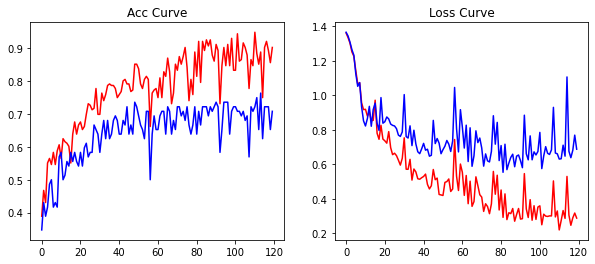

In [10]:
# Acc curve, Loss curve
plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.title("Acc Curve")
plt.plot(hist["acc"], color="red")
plt.plot(hist["val_acc"], color="blue")
plt.subplot(1, 2, 2)
plt.title("Loss Curve")
plt.plot(hist["loss"], color="red")
plt.plot(hist["val_loss"], color="blue")
plt.savefig(os.path.join('learning_curve', '{}.png'.format("EEGNet_"+scheme)), dpi=300)
plt.show()

In [13]:
# load pre-trained model
best_epoch = hist["val_loss"].argmin() # TODO: determine the `BEST` epoch
test_model_path = os.path.join(savepath, "{}-ep{}.pth".format("EEGNet", best_epoch))
checkpoint = torch.load(test_model_path, map_location="cpu")  # load .pth
model.load_state_dict(checkpoint["state_dict"])  # set model weight

# testing on subject S01 test (E) session
mat = loadmat(os.path.join(DATASET_DIR_TEST, f"BCIC_S01_E.mat"))
x, y = mat["x_test"], mat["y_test"].squeeze()
x = torch.from_numpy(x)
y = torch.from_numpy(y).long()
x = x.unsqueeze(1)
y = F.one_hot(y, 4)

print("test: {}, {}".format(x.size(), y.size()))

testset = torch.utils.data.TensorDataset(x, y)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
loss, acc, gt, pred = evalate_an_epoch(model, test_loader, loss_fn)

print("Accuracy of testing on EEGNet:", acc)

test: torch.Size([288, 1, 22, 562]), torch.Size([288, 4])
Accuracy of testing on EEGNet: 0.7256944444444444


### fine-tuning (SI+FT)

In [21]:
### TODO: build the fine-tuning dataloader ###

mat_T = loadmat(os.path.join(DATASET_DIR, "BCIC_S0{}_T.mat".format(subject_id)))
x_data, y_data = mat_T["x_train"], mat_T["y_train"].squeeze()
x_fine_tune = np.zeros((0, *x_data.shape[1:]), dtype=x_data.dtype)
y_fine_tune = np.zeros((0, ), dtype=y_data.dtype)

dataset_size = len(x_data)
indices = list(range(dataset_size))
np.random.seed(42)
np.random.shuffle(indices)

x_fine_tune = np.append(x_fine_tune, x_data[indices], axis=0)
y_fine_tune = np.append(y_fine_tune, y_data[indices], axis=0) 

# numpy array to tensor
x_fine_tune = torch.from_numpy(x_fine_tune)
y_fine_tune = torch.from_numpy(y_fine_tune).long()

# tensor reshape for training
x_fine_tune = x_fine_tune.unsqueeze(1)
y_fine_tune = F.one_hot(y_fine_tune, 4)

print("Fine-tuning set for training: {}, {}".format(x_fine_tune.size(), y_fine_tune.size()))

# build training and validation dataloader
ftset = torch.utils.data.TensorDataset(x_fine_tune, y_fine_tune)
ft_loader = torch.utils.data.DataLoader(ftset, batch_size=batch_size, shuffle=True, num_workers=2)

Fine-tuning set for training: torch.Size([288, 1, 22, 562]), torch.Size([288, 4])


In [35]:
# load pre-trained model
### TODO ###
eegmodel = SCCNet
model = eegmodel(x_fine_tune.size(2), x_fine_tune.size(3), 4, **kwargs)
model = model.to(device)

savepath2 = "checkpoints/SCCNet_si"
ep_num = 211 # TODO: the pre-trained epoch you want to tuning
model_path = os.path.join(savepath2, "{}-ep{}(selected).pth".format("SCCNet", ep_num))
checkpoint = torch.load(model_path, map_location="cpu")  # load .pth
model.load_state_dict(checkpoint["state_dict"])  # set model weight

# Optional: lock pre-trained weight
for name, param in model.named_parameters():
    if name in ['classifier.weight', 'classifier.bias']:
        param.requires_grad = True
        
parameters = filter(lambda p: p.requires_grad, model.parameters())

loss_fn = nn.CrossEntropyLoss()  # loss function, can be modified
opt_fn = torch.optim.Adam(parameters, lr=lr, weight_decay=5e-04)  # optimizer, CAN be modified

### TODO: fine-tuning training loop ###

def train_an_epoch(model, data_loader, loss_fn, optimizer):
    model.train()
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.9)

    a, b = 0, 0  # hit sample, total sample
    epoch_loss = np.zeros((len(data_loader), ))
    for i, (x_batch, y_batch) in enumerate(data_loader):
        x_batch, y_batch = x_batch.to(device, dtype=torch.float), y_batch.to(device, dtype=torch.float)
        
        ### TODO ###
        # TODO: zero grad optimizer
        optimizer.zero_grad()
        # TODO: get model prediction
        output = model(x_batch)
        # TODO: calc loss
        loss = loss_fn(output, y_batch)
        # TODO: back propagation
        loss.backward()
        # TODO: step the optimizer
        optimizer.step()
        
        epoch_loss[i] = loss.item()
        b += y_batch.size(0)
        a += torch.sum(y_batch.argmax(dim=1) == output.argmax(dim=1)).item()
    scheduler.step()
    return epoch_loss.mean(), a / b  # return the loss and acc

hist = dict(
    loss=np.zeros((epochs, )), val_loss=np.zeros((epochs, )),
    acc=np.zeros((epochs, )), val_acc=np.zeros((epochs, ))
)
clock_ini = time.time()
for ep in range(epochs):
    loss, acc = train_an_epoch(model, ft_loader, loss_fn, opt_fn)
    loss, acc, _, _ = evalate_an_epoch(model, ft_loader, loss_fn)
    print("Epoch {}: loss={:.4f}, acc={:.4f}".format(ep, loss, acc))
    hist["loss"][ep] = loss
    hist["acc"][ep] = acc

    if True:
        # save the pre-trained weight in each epoch, CAN be modified
        checkpoint = dict(epoch=-1, state_dict=model.state_dict(), loss=loss)
        torch.save(checkpoint, os.path.join(savepath, f"SCCNet-ep{ep}.pth"))
print("time spend: {:.2f} sec".format(time.time() - clock_ini))

Epoch 0: loss=0.7004, acc=0.7049
Epoch 1: loss=0.6708, acc=0.7153
Epoch 2: loss=0.6682, acc=0.7083
Epoch 3: loss=0.6362, acc=0.7153
Epoch 4: loss=0.6087, acc=0.7465
Epoch 5: loss=0.5944, acc=0.7465
Epoch 6: loss=0.5934, acc=0.7326
Epoch 7: loss=0.5754, acc=0.7535
Epoch 8: loss=0.5629, acc=0.7535
Epoch 9: loss=0.5543, acc=0.7500
Epoch 10: loss=0.5357, acc=0.7708
Epoch 11: loss=0.5412, acc=0.7604
Epoch 12: loss=0.5202, acc=0.7847
Epoch 13: loss=0.5036, acc=0.7917
Epoch 14: loss=0.5104, acc=0.7882
Epoch 15: loss=0.4910, acc=0.7917
Epoch 16: loss=0.4821, acc=0.7917
Epoch 17: loss=0.4692, acc=0.8194
Epoch 18: loss=0.4686, acc=0.7951
Epoch 19: loss=0.4728, acc=0.8021
Epoch 20: loss=0.4528, acc=0.8264
Epoch 21: loss=0.4457, acc=0.8299
Epoch 22: loss=0.4342, acc=0.8299
Epoch 23: loss=0.4314, acc=0.8333
Epoch 24: loss=0.4296, acc=0.8403
Epoch 25: loss=0.4235, acc=0.8333
Epoch 26: loss=0.4093, acc=0.8542
Epoch 27: loss=0.4026, acc=0.8507
Epoch 28: loss=0.4025, acc=0.8507
Epoch 29: loss=0.4057, a

## Test

In [37]:
# load pre-trained model
best_epoch = hist["loss"].argmin() # TODO: determine the `BEST` epoch
test_model_path = os.path.join(savepath, "{}-ep{}.pth".format("SCCNet", best_epoch))
checkpoint = torch.load(test_model_path, map_location="cpu")  # load .pth
model.load_state_dict(checkpoint["state_dict"])  # set model weight

# testing on subject S01 test (E) session
mat = loadmat(os.path.join(DATASET_DIR_TEST, f"BCIC_S01_E.mat"))
x, y = mat["x_test"], mat["y_test"].squeeze()
x = torch.from_numpy(x)
y = torch.from_numpy(y).long()
x = x.unsqueeze(1)
y = F.one_hot(y, 4)

print("test: {}, {}".format(x.size(), y.size()))

testset = torch.utils.data.TensorDataset(x, y)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
loss, acc, gt, pred = evalate_an_epoch(model, test_loader, loss_fn)

print("Accuracy of testing on SCCNet:", acc)

test: torch.Size([288, 1, 22, 562]), torch.Size([288, 4])
Accuracy of testing on SCCNet: 0.8229166666666666


### Analyzing
You need to do some further analysis including
- confusion matrix, 
- topographic maps for spatial kernel weights in SCCNet

You need to do these on your own in this section

Confusion matrix

In [28]:
# mne doc: https://mne.tools/stable/python_reference.html
# "data_detail.json" in BCI_hw3_dataset/ provides you with all channel names in this dataset. It will help you to plot a topoplot.

from sklearn.metrics import confusion_matrix
import seaborn as sn

def plot_confusion_matrix(y_true, y_pred, labels, fn, model_name, train_scheme, acc):
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(labels)), normalize='true')
    fig, ax = plt.subplots()
    sn.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt='.1f')
    ax.set_xlabel('Prediction')
    ax.set_ylabel('Ground truth')
    ax.xaxis.set_ticklabels(labels, rotation=45)
    ax.yaxis.set_ticklabels(labels, rotation=0)
    plt.title('Comfusion matrix\n Model: {}\n Training Scheme: {}\n Accuracy: {}'.format(model_name, train_scheme, acc))
    plt.savefig(fn, dpi=300)

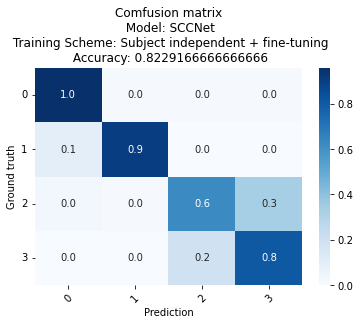

In [38]:
plot_confusion_matrix(gt, pred, [0, 1, 2, 3], os.path.join('cm', '{}.png'.format("SCCNet_sift"))
                      , "SCCNet", "Subject independent + fine-tuning", acc)

Topographic maps

In [319]:
# Load channel positions
montage = mne.channels.make_standard_montage('standard_1020')
ch_pos = montage.get_positions()

In [320]:
weights = model.state_dict()['conv1.0.weight'].detach().cpu().numpy()
n_channels = weights.shape[0]
weights = weights.reshape(n_channels, -1)
weights = weights.transpose()

In [321]:
# Create Info object
ch_names = ['Fz', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP3', 'CP1', 'CPz'
            , 'CP2', 'CP4', 'P1', 'Pz', 'P2', 'POz']
info = mne.create_info(ch_names=ch_names, sfreq=125.0, ch_types='eeg')
info.set_montage(montage)

# Create Evoked object
evoked = mne.EvokedArray(weights, info, tmin=0)

In [322]:
ch_pos_selected = []
for i in range(22):
    ch_pos_selected.append(ch_pos['ch_pos'][ch_names[i]][:-1])

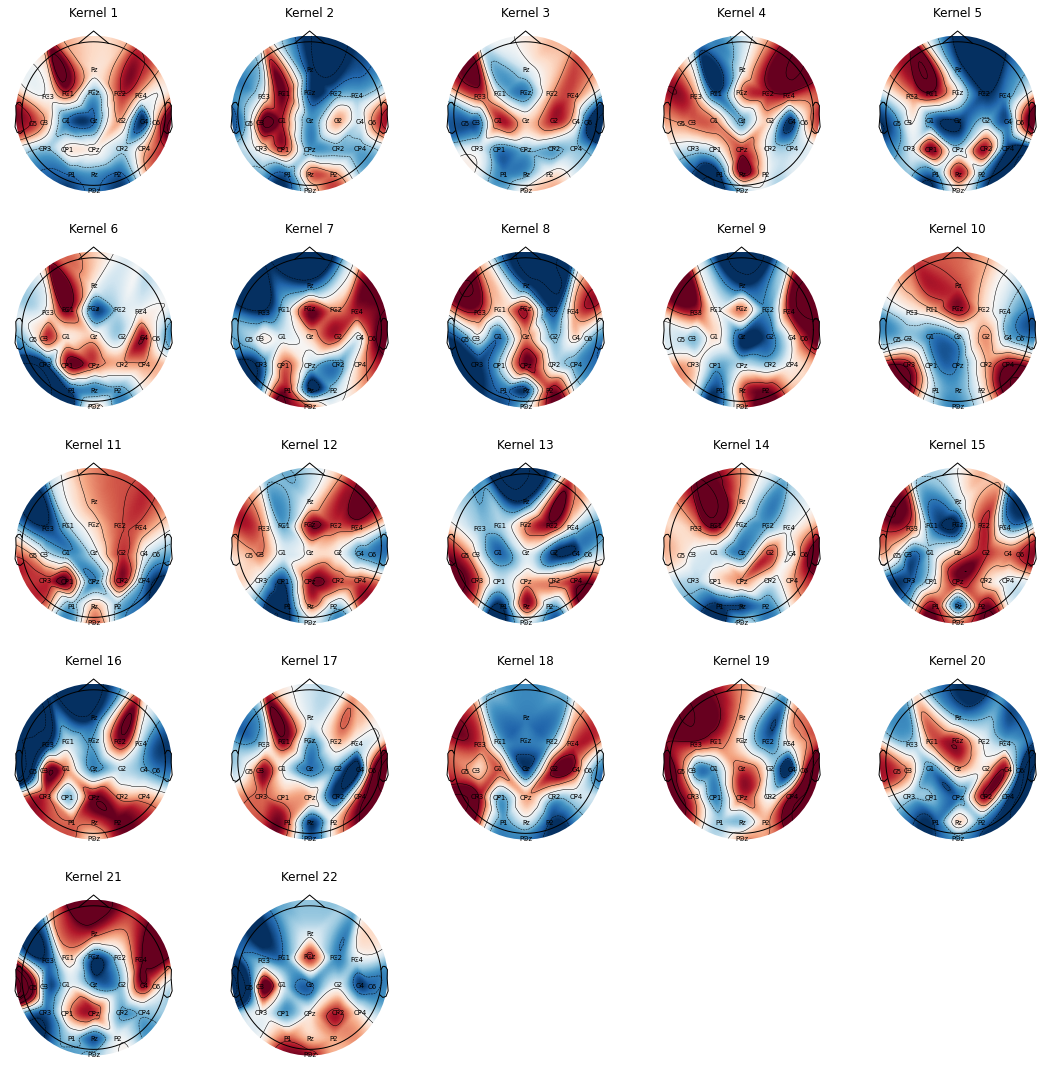

In [323]:
ch_pos_selected = np.array(ch_pos_selected)
# Plot topographic maps
fig = plt.figure(figsize=(12, 12))

# Define positions and sizes of each subplot
x_positions = [0, 0.25, 0.5, 0.75, 1, 0, 0.25, 0.5, 0.75, 1, 0, 0.25, 0.5, 0.75, 1, 0, 0.25, 0.5, 0.75, 1
               , 0, 0.25, 0.5, 0.75, 1]
y_positions = [1]*5 + [0.75]*5 + [0.5]*5 + [0.25]*5 + [0]*5
widths = [0.2]*5*5
heights = [0.2]*5*5

# Plot topographic maps
for i in range(25):
    if i >= evoked.data.shape[1]:
        # Skip any index that is out of bounds
        continue
        
    # Create subplot
    ax = fig.add_axes([x_positions[i], y_positions[i], widths[i], heights[i]])
    
    # Plot topomap
    mne.viz.plot_topomap(evoked.data[:, i], ch_pos_selected, names=ch_names, axes=ax, show=False)
    ax.set_title('Kernel {}'.format(i+1))
    
    # Set y-axis ticks
    yticks = ax.get_yticks()
    ax.set_yticks(yticks)

plt.show()

## Generate Submission csv File

In [84]:
savepath = "./checkpoints/SCCNet_sift"

In [266]:
eegmodel = SCCNet # function alias, should be EEGNet, ShallowConvNet, SCCNet, SCCNet_v2
kwargs = dict(fs=125.0, dropoutRate=0.5) # custom args for different EEG model
model = eegmodel(22, 562, 4, **kwargs)
best_epoch = hist["loss"].argmin()
test_model_path = os.path.join(savepath, "{}-ep{}.pth".format("SCCNet", best_epoch))
checkpoint = torch.load(test_model_path, map_location="cpu") 
model.load_state_dict(checkpoint["state_dict"])

model = model.to(device)

model.eval()
fd = open("sample_sd.csv", "w", newline='')
csv_writer = csv.writer(fd)
csv_writer.writerow(["id", "Category"])
for sid in ["05", "06","0A", "0B", "0C"]:
    mat = loadmat(os.path.join(DATASET_DIR_EXAM, f"BCIC_S{sid}_E.mat"))
    x = torch.from_numpy(mat["x_test"])
    x = x.unsqueeze(1).to(device, dtype=torch.float)
    p = model(x).argmax(dim=1).detach().cpu().numpy()
    for epoch_id, label in enumerate(p):
        csv_writer.writerow([f"S{sid}_{epoch_id}", label])
fd.close()